In [508]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, entropy
from matplotlib.patches import Ellipse

In [240]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%precision %.5f
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rc('text', usetex=True)
plt.rc('font',**{'family':'serif','serif':['Palatino']})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Constants

In [3]:
DATA_DIR = "classification_data_HWK2/"
COLS = ["red", "blue","green", "orange", "black", "cyan"]
MARKS = ["^","+","*","o","x","."]

## Reading data

In [9]:
D = {}
for t in ["data", "test"]:
    D[t] = pd.read_csv(DATA_DIR + "EMGaussian" + "." + t, sep = ' ', names = ["x1", "x2"])

## Plot tools

In [528]:
def as_si(x, ndp):
    """
    Credits to xnx
    https://stackoverflow.com/questions/31453422/displaying-numbers-with-x-instead-of-e-scientific-notation-in-matplotlib
    """
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    return r'{m:s}\times 10^{{{e:d}}}'.format(m=m, e=int(e))


def make_grid(data=None,xmin=-5,xmax=5,ymin=-5,ymax=5,step=20):
    """ Cree une grille sous forme de matrice 2d de la liste des points
    :param data: pour calcluler les bornes du graphe
    :param xmin: si pas data, alors bornes du graphe
    :param xmax:
    :param ymin:
    :param ymax:
    :param step: pas de la grille
    :return: une matrice 2d contenant les points de la grille
    """
    if data is not None:
        xmax, xmin, ymax, ymin = np.max(data[:,0]),  np.min(data[:,0]), np.max(data[:,1]), np.min(data[:,1])
    x, y =np.meshgrid(np.arange(xmin,xmax,(xmax-xmin)*1./step), np.arange(ymin,ymax,(ymax-ymin)*1./step))
    grid=np.c_[x.ravel(),y.ravel()]
    return grid, x, y

def plot_data(data, labels = None):
    """
    Affiche des donnees 2D
    :param data: matrice des donnees 2d
    :param labels: vecteur des labels (discrets)
    :return:
    """
    cols,marks = ["red", "blue","green", "orange", "black", "cyan"],[".","+","*","o","x","^"]
    if labels is None:
        plt.scatter(data[:,0],data[:,1], c='r',  marker="x")
        return
    for i,l in enumerate(sorted(list(set(labels.flatten())))):
        plt.scatter(data[labels==l,0],data[labels==l,1],c=cols[i],marker=marks[i])
        
def plot_frontiere(data, f, step = 200):
    """ Trace un graphe de la frontiere de decision de f
    :param data: donnees
    :param f: fonction de decision
    :param step: pas de la grille
    :return:
    """
    grid,x, y = make_grid(data = data, step = step)
    plt.contourf(x, y, f(grid).reshape(x.shape), colors=('gray', 'blue'), levels=[-1,0,1], alpha=0.3)
    
def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip

## Plotting data

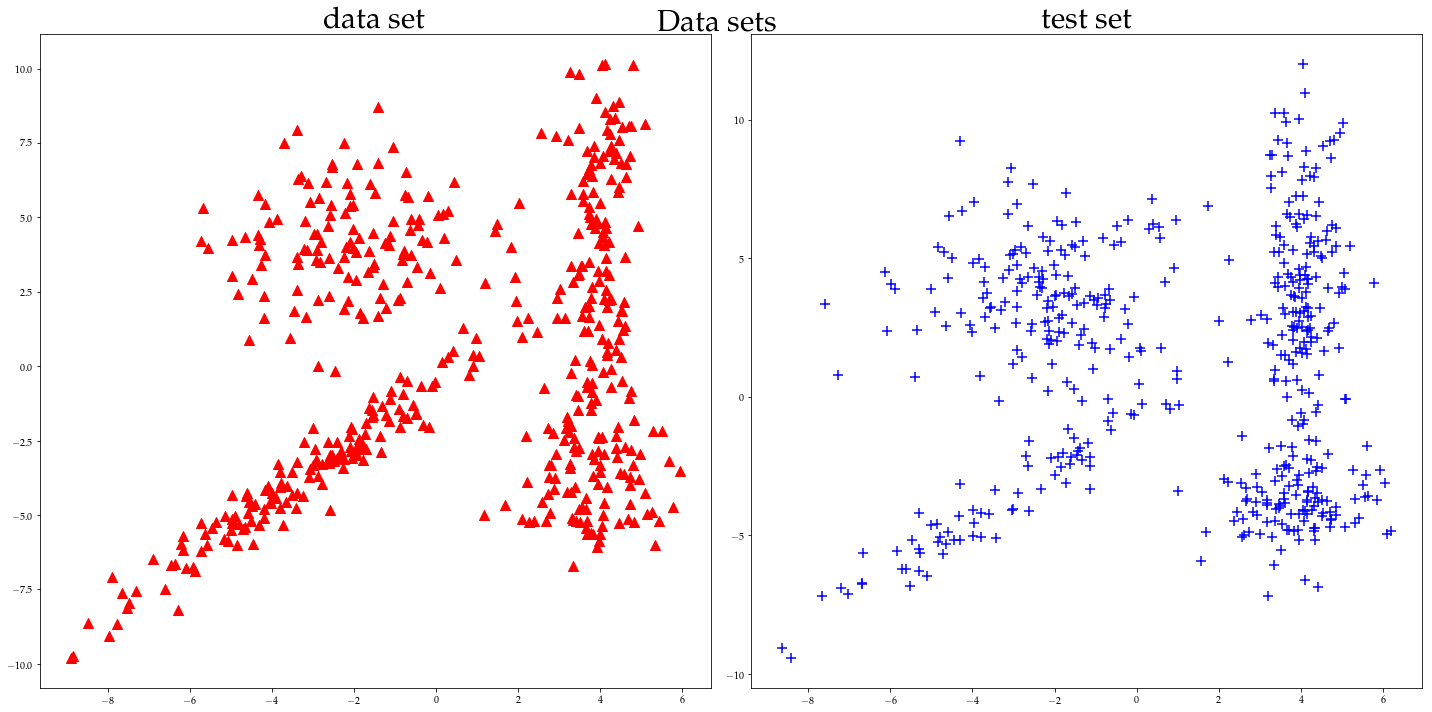

In [14]:
f, ax = plt.subplots(1, 2, figsize = (20, 10))

for j, t in enumerate(["data", "test"]):
    x = D[t].as_matrix()[:, :2]
    ax[j].scatter(x[:, 0], x[:, 1],
                  c = COLS[j], marker=MARKS[j], s = 100)
    ax[j].set_title(t + " set", size = 30);

f.suptitle("Data sets", fontsize = 30)
f.tight_layout();

# Classes

## Kmeans

In [233]:
class K_means(object):
    """
    K-means clustering class
    """
    def __init__(self, K):
        self.K = K
        self.C = None
        self.A = None
        self.distorsion = []
        return
    def _random_centroid(self, datax):
        """
        Draw centroids chosen uniformly at random among the data
        """
        np.random.shuffle(datax)
        return datax[:self.K].reshape(self.K, 1, -1)
    def _one_pass(self, datax):
        """
        One pass of the K_means alternative minimization by computing the distance matrix
        1. Assign each point to the closet centroid
        2. Compute distorsion for each pass and add it to the histogram
        """
        # Compute the distance matrix from each point to each centroid
        distance_matrix = np.linalg.norm(np.tile(datax, (self.K, 1, 1)) - self.C, axis = 2)
        # Get the argmin of the distance for all centroids
        self.A = distance_matrix.argmin(axis = 0)
        # Get the current value of distorsion
        ## Store the minimum distance
        min_dist = distance_matrix.min(axis = 0)
        self.distorsion.append((min_dist ** 2).sum())
        # Recompute the centroids
        self.C = np.array([(lambda a : datax[a].sum(axis = 0)/a.sum())(self.A == k)\
                           for k in range(self.K)]).reshape(self.K, 1, -1)
    def fit(self, datax):
        """
        """
        # Initialisation
        ## Of centroids
        self.C = self._random_centroid(datax)
        ## Stop condition
        stop = False
        while (stop == False):
            self._one_pass(datax)
            if (len(self.distorsion) > 1):
                stop = True if self.distorsion[-2] - self.distorsion[-1] < 1 else False
        return self.C, self.A
    def predict(self, datax):
        """
        Predict cluster given current centroids
        """
        # Compute the distance matrix from each point to each centroid
        distance_matrix = np.linalg.norm(np.tile(datax, (self.K, 1, 1)) - self.C, axis = 2)
        return distance_matrix.argmin(axis = 0)

In [482]:
class EM(object):
    """
    EM method for clustering
    """
    def __init__(self, K):
        self.K = K
        self.mu = None
        self.sigma = None
        self.pi = None 
        self.q = None
        self.L = []
        return
    def _e_step(self, x):
        """
        Expectation step
        """
        gaussiens = np.array([multivariate_normal(self.mu[i].reshape(-1),
                                         self.sigma[i]
                                        ).pdf(x) for i in range(self.K)])
        self.q = gaussiens * self.pi
        self.q = self.q / self.q.sum(axis = 0)
        
#         print ("---- E-step ---- ")
#         print("q : {}".format(self.q.shape))
        self.L.append((self.q * (gaussiens + np.log(self.pi))).sum()\
                      + entropy(self.q).sum())

        self.q = self.q.reshape(self.K, len(x), 1)
        return
    def _m_step(self, x):
        """
        Maximization step
        """
        self.mu = (x * self.q).sum(axis = 1) / self.q.sum(axis = 1)
        self.mu = self.mu.reshape(self.K, 1, -1)
        self.sigma = np.matmul(np.transpose(x-self.mu, (0, 2, 1)),
                               (x-self.mu) * self.q) / self.q.sum(axis = 1)\
                                .reshape(self.K, 1, 1)
        self.pi = self.q.sum(axis = 1) / len(x)
        return
    def _initialization(self, x):
        """
        Initializes mu, sigma and pi
        """
        self.mu, A = K_means(self.K).fit(x)
        self.q = np.zeros((self.K, len(x), 1))
        for i,j in np.ndenumerate(A):
            self.q[j, i] = 1
        self.sigma = np.matmul(np.transpose(x-self.mu, (0, 2, 1)),
                               (x-self.mu) * self.q) / self.q.sum(axis = 1)\
                                .reshape(self.K, 1, 1)
        self.pi = self.q.sum(axis = 1) / len(x)
#         print ("---- Init ---- ")
#         print("mu : {} - q : {} - sigma : {} - pi : {}".format(self.mu.shape,
#                                                               self.q.shape,
#                                                               self.sigma.shape,
#                                                               self.pi.shape))
    def fit(self, x):
        """
        """
        # Initialisation
        ## Of centroids
        self._initialization(x)
        stop = False
        while (stop == False):
            self._e_step(x)
            self._m_step(x)
            if (len(self.L) > 2 and np.abs(self.L[-2] - self.L[-1]) < 10e-3):
                stop = True
        return 
#         ## Stop condition
#         stop = False
#         while (stop == False):
#             self._one_pass(datax)
#             if (len(self.distorsion) > 1):
#                 stop = True if self.distorsion[-2] - self.distorsion[-1] < 1 else False
#         return self.C, self.A
#     def predict(self, datax):
#         """
#         Predict cluster given current centroids
#         """
#         # Compute the distance matrix from each point to each centroid
#         distance_matrix = np.linalg.norm(np.tile(datax, (self.K, 1, 1)) - self.C, axis = 2)
#         return distance_matrix.argmin(axis = 0)

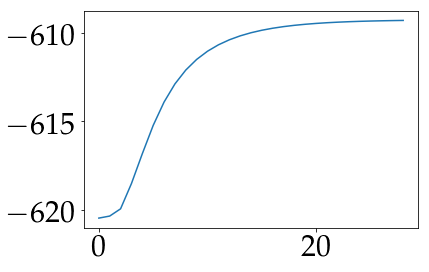

In [529]:
clf = EM(4)
clf.fit(x)
plt.plot(clf.L);

In [537]:
clf.mu.reshape(4, 2)

array([[-3.08450794, -3.53191613],
       [-2.19419509,  3.79119541],
       [ 4.03827376,  3.95589351],
       [ 3.88666731, -3.88929561]])

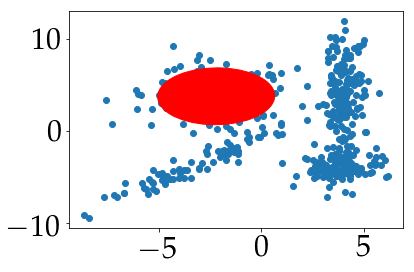

In [545]:
plt.scatter(x[:, 0], x[:, 1])
plot_cov_ellipse(clf.sigma[1], clf.mu[1].T, nstd = 1.65, color = "red")

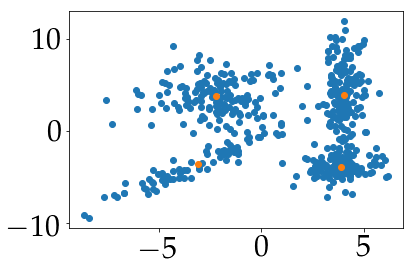

In [505]:
cen = clf.mu.reshape(4, -1)
plt.scatter(x[:, 0], x[:, 1])
plt.scatter(cen[:, 0], cen[:, 1])

# Results

## K-means with random initializations - training data

Moyenne de distorsion : 3239.1404369113247 - et écart-type : 1.076615582066236
----- Centroide 1 -----
moyenne  : [-3.72847427 -4.16766382]
écart-type : [ 0.07093637  0.08426431]
----- Centroide 1 -----
moyenne  : [-2.20959275  4.12403497]
écart-type : [ 0.04492002  0.09089237]
----- Centroide 1 -----
moyenne  : [ 3.79729568  5.05373315]
écart-type : [ 0.00659189  0.04730235]
----- Centroide 1 -----
moyenne  : [ 3.46207098 -2.75204985]
écart-type : [ 0.10903265  0.09955119]


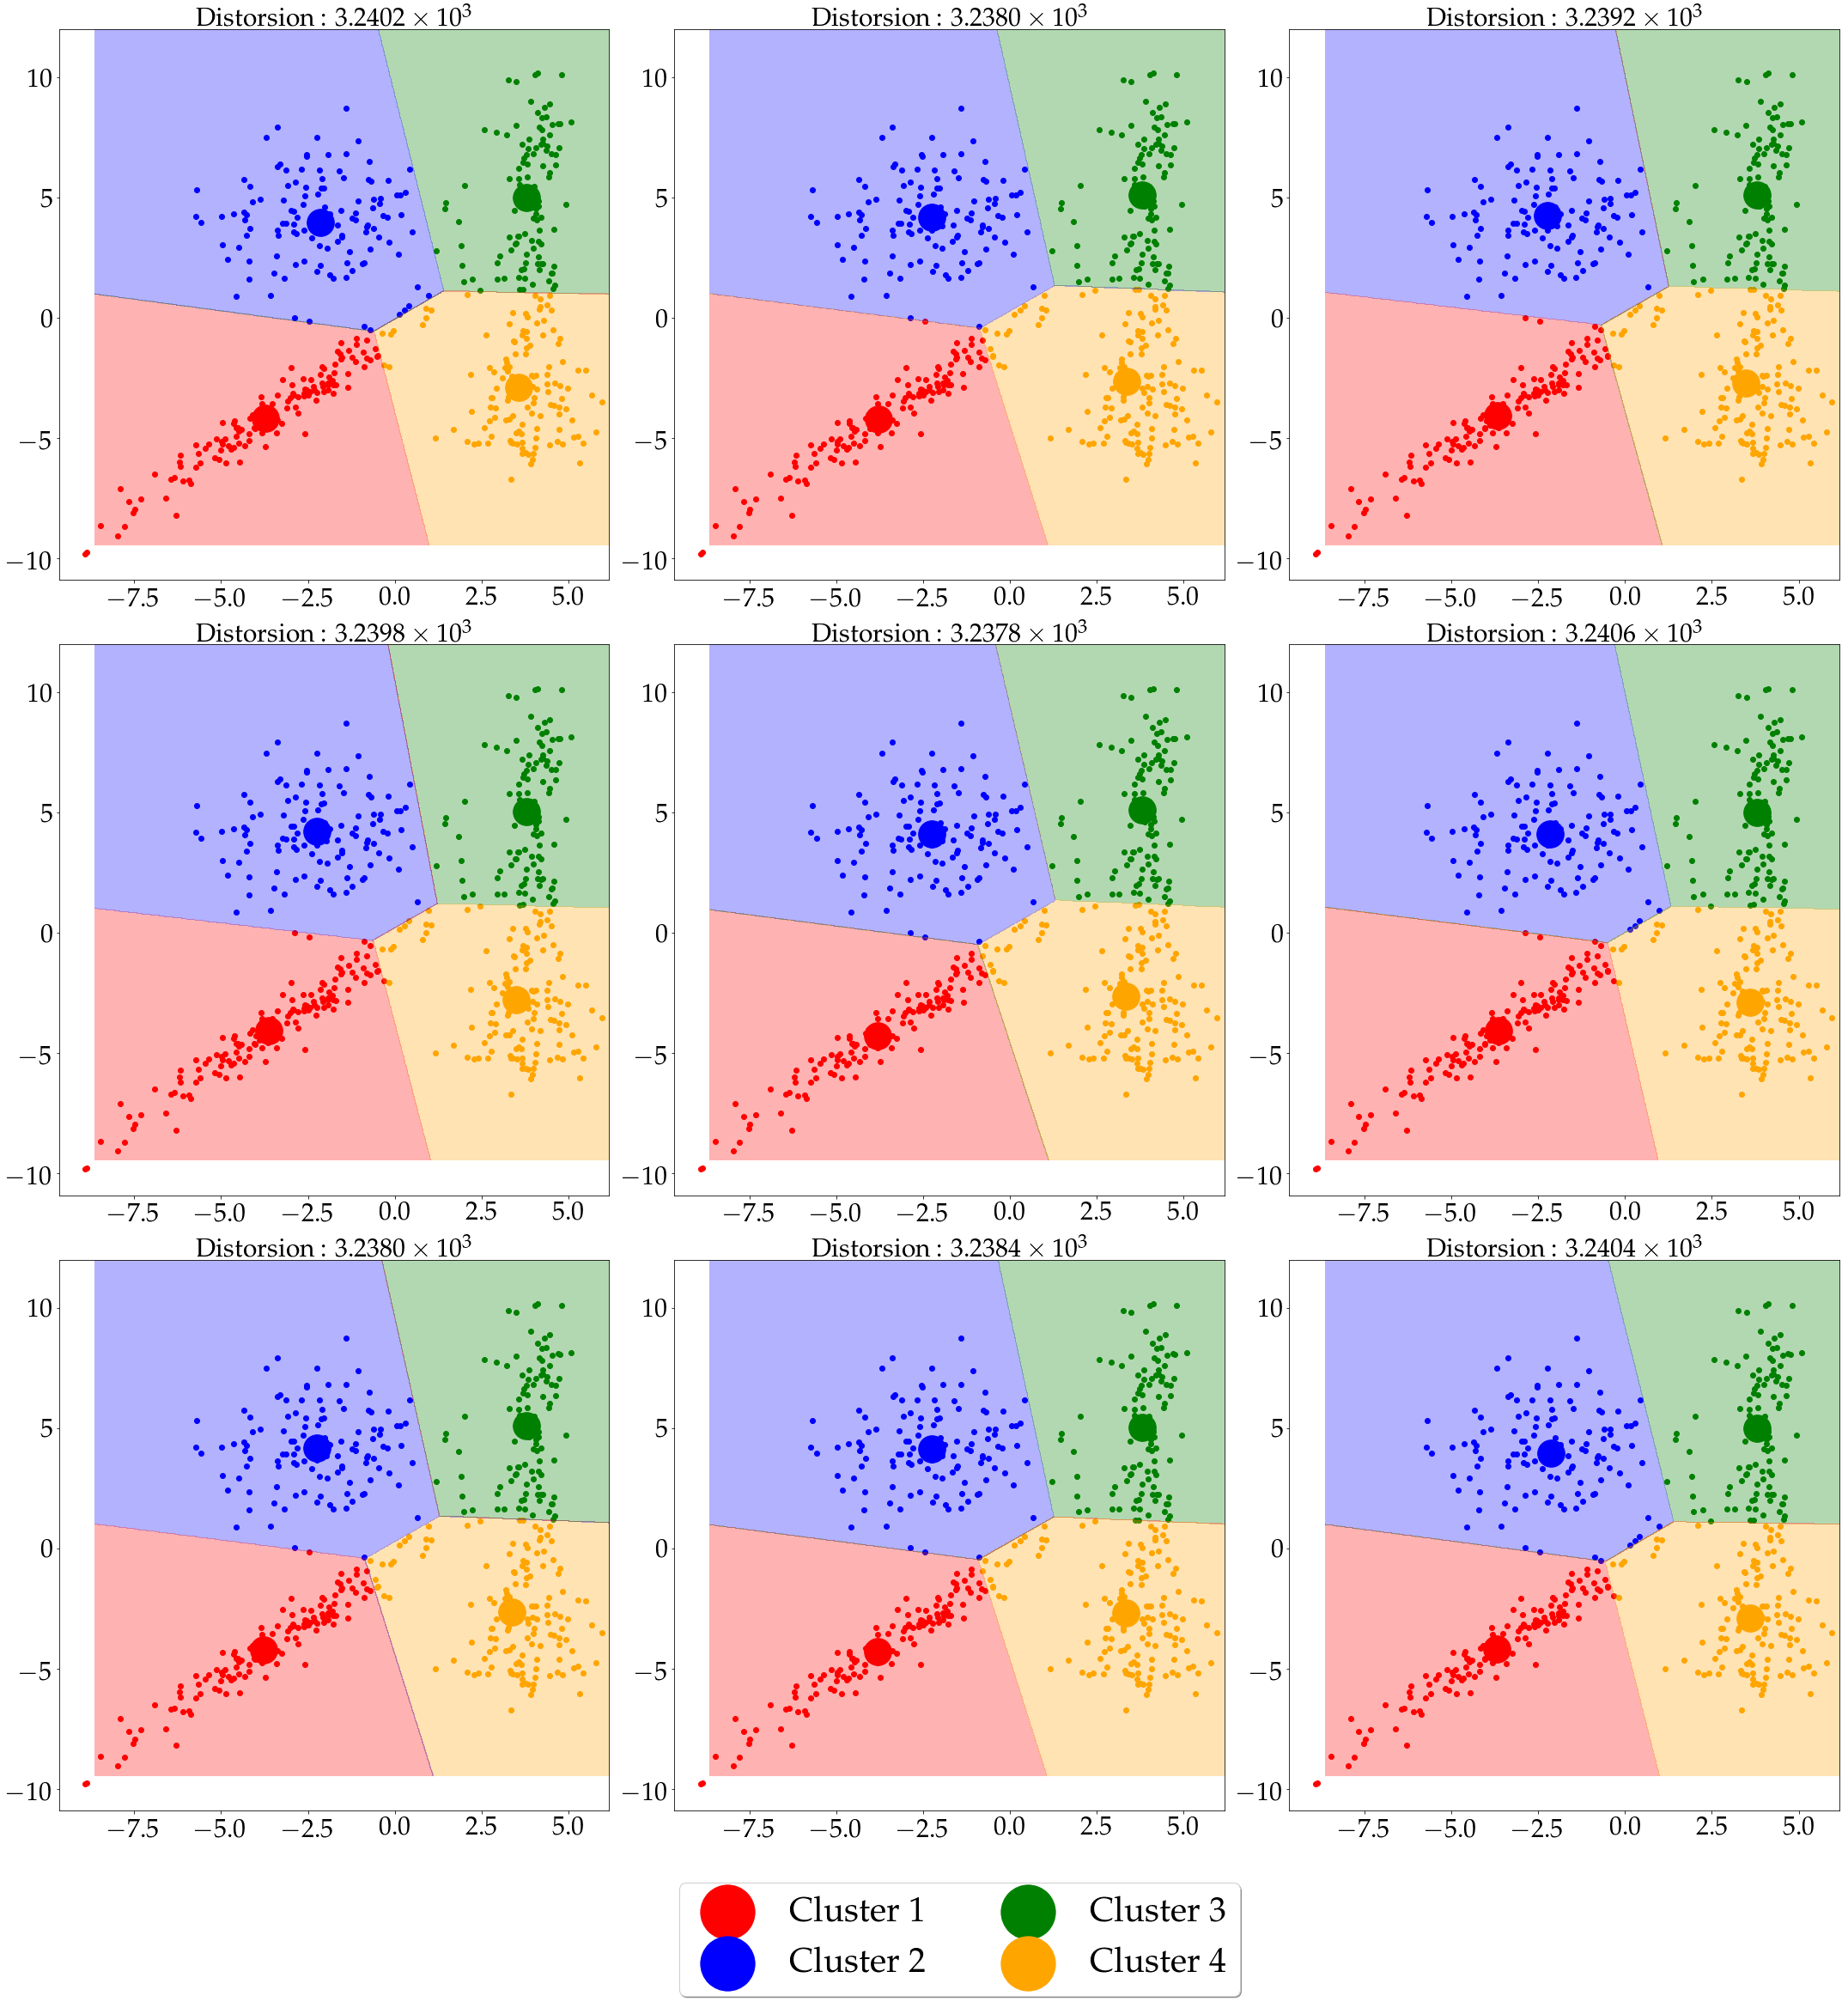

In [547]:
w, h = 3, 3

f, ax = plt.subplots(h, w, figsize = (10 * w, 10 * h))

datax = D['data'].as_matrix()
K = 4

distorsion = []
Cen = {0 : [], 1 : [], 2 : [], 3 : []}

for k in range(w * h):
    # print ("----------------- number {} --------------------".format(k))
    classifier = K_means(K)
    # Fit the classifier
    C, A = classifier.fit(datax)
    C = C.reshape(K, 2)
    for i,j in enumerate(np.arctan2(C[:, 0], C[:, 1]).argsort()):
        Cen[i].append(C[j])
        ax[k // w][k % w].scatter(datax[A == j][:, 0],
                                  datax[A == j][:, 1],
                                  c = COLS[i])
        ax[k // w][k % w].scatter(C[j, 0],
                                  C[j, 1],
                                  c = COLS[i],
                                  marker = "o",
                                  s = 1000,
                                  label = "Cluster {}".format(i + 1)
                                 )
    grid, x_grid, y_grid = make_grid(data = x, step = 1000)
    ax[k // w][k % w].contourf(x_grid, y_grid,
                               classifier.predict(grid).reshape(x_grid.shape),
                               colors = [COLS[c] for c in np.arctan2(C[:, 0], C[:, 1])\
                                         .argsort().argsort()],
                               levels = [-1, 0, 1, 2, 3],
                               alpha = 0.3,
                              )
    distorsion.append(classifier.distorsion[-1])
    ax[k // w][k % w].set_title(r"Distorsion : ${}$".format(as_si(classifier.distorsion[-1], 4)),
                               fontsize = 30)

ax[k // w][k % w].legend(loc='upper center', bbox_to_anchor=(-0.6, -0.1),
            fancybox=True, shadow=True, ncol=2, fontsize = 40,
            markerscale = 2)

# f.savefig("images/4_a.png",  bbox_inches='tight', pad_inches=1)
f.tight_layout();

print ("Moyenne de distorsion : {} - et écart-type : {}"\
       .format(np.mean(distorsion),np.std(distorsion)))
for k in Cen.keys():
    Cen[k] = np.array(Cen[k])
    print ("----- Centroide 1 -----")
    print ("moyenne  : {}\nécart-type : {}"\
       .format(np.mean(Cen[k], axis = 0), np.std(Cen[k], axis = 0)))

## EM clustering with K-means initialization

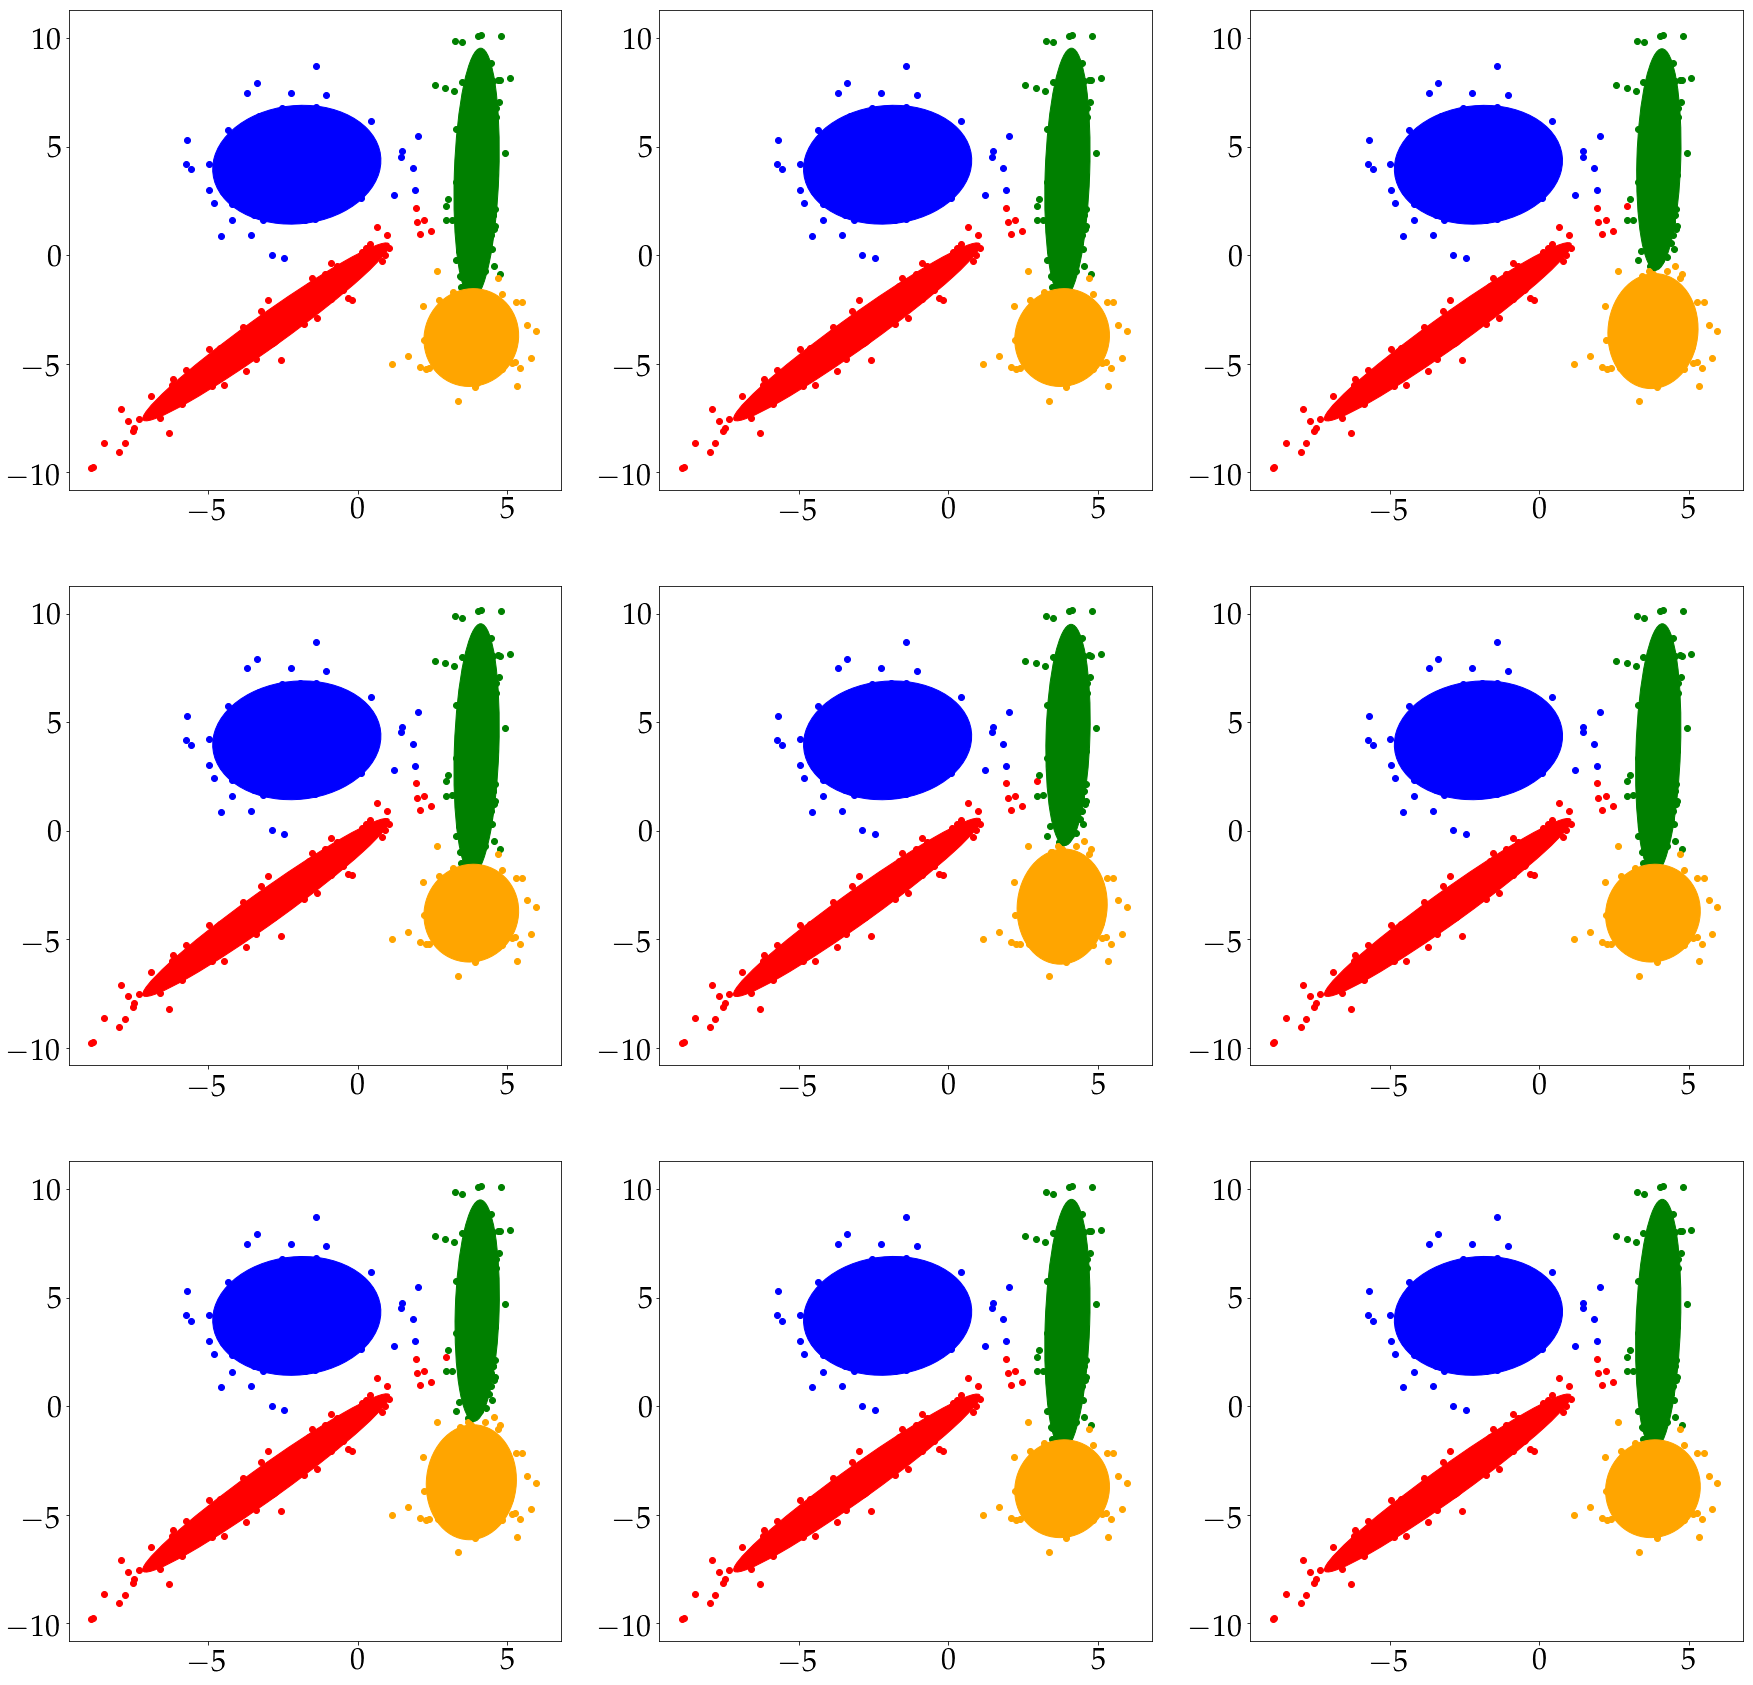

In [550]:
w, h = 3, 3

f, ax = plt.subplots(h, w, figsize = (10 * w, 10 * h))

datax = D['data'].as_matrix()
K = 4

distorsion = []
Cen = {0 : [], 1 : [], 2 : [], 3 : []}

for k in range(w * h):
    # print ("----------------- number {} --------------------".format(k))
    classifier = EM(K)
    # Fit the classifier
    classifier.fit(datax)
    A = classifier.q.argmax(axis = 0).astype(int)
    C = classifier.mu.reshape(K, 2)
    for i,j in enumerate(np.arctan2(C[:, 0], C[:, 1]).argsort()):
        Cen[i].append(C[j])
        ax[k // w][k % w].scatter(datax[A.reshape(-1) == j][:, 0],
                                  datax[A.reshape(-1) == j][:, 1],
                                  c = COLS[i])
        ax[k // w][k % w].scatter(C[j, 0],
                                  C[j, 1],
                                  c = COLS[i],
                                  marker = "o",
                                  s = 1000,
                                  label = "Cluster {}".format(i + 1)
                                 )
        plot_cov_ellipse(classifier.sigma[j],
                         classifier.mu[j].T,
                         nstd = 1.65,
                         ax = ax[k // w][k % w],
                         color = COLS[i])
        
#     distorsion.append(classifier.distorsion[-1])
#     ax[k // w][k % w].set_title(r"Distorsion : ${}$".format(as_si(classifier.distorsion[-1], 4)),
#                                fontsize = 30)

# ax[k // w][k % w].legend(loc='upper center', bbox_to_anchor=(-0.6, -0.1),
#             fancybox=True, shadow=True, ncol=2, fontsize = 40,
#             markerscale = 2)

# f.savefig("images/4_a.png",  bbox_inches='tight', pad_inches=1)
# f.tight_layout();

# print ("Moyenne de distorsion : {} - et écart-type : {}"\
#        .format(np.mean(distorsion),np.std(distorsion)))
# for k in Cen.keys():
#     Cen[k] = np.array(Cen[k])
#     print ("----- Centroide 1 -----")
#     print ("moyenne  : {}\nécart-type : {}"\
#        .format(np.mean(Cen[k], axis = 0), np.std(Cen[k], axis = 0)))

# Test zone

In [543]:
datax[A.reshape(-1) == 0]

array([[  4.2408  ,   8.3093  ],
       [  3.9743  ,   1.3937  ],
       [  3.8583  ,   7.415   ],
       [  3.7341  ,   5.3454  ],
       [  4.0845  ,  -0.19958 ],
       [  4.3998  ,   0.54835 ],
       [  4.2754  ,   7.2554  ],
       [  4.723   ,   7.072   ],
       [  4.3602  ,   8.3541  ],
       [  4.4675  ,   8.8786  ],
       [  4.6984  ,   8.0832  ],
       [  3.6935  ,  -0.51765 ],
       [  3.5429  ,   3.3781  ],
       [  3.2878  ,   3.3672  ],
       [  4.2493  ,   7.8125  ],
       [  3.7617  ,   0.18421 ],
       [  3.7886  ,  -1.2331  ],
       [  4.1146  ,   8.5452  ],
       [  3.352   ,   2.8239  ],
       [  4.3524  ,   6.9648  ],
       [  4.145   ,   4.6411  ],
       [  4.2704  ,   2.2615  ],
       [  4.3867  ,   7.1527  ],
       [  4.0098  ,   5.4786  ],
       [  4.5484  ,  -0.48432 ],
       [  4.0438  ,   0.92554 ],
       [  3.4568  ,  -0.99771 ],
       [  3.4015  ,   0.21089 ],
       [  3.5987  ,   1.1724  ],
       [  4.003   ,   6.8276  ],
       [  